In [1]:
#How the economic/population growth of countries is releated to the climate change?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math

In [3]:
df = pd.read_csv('data/owid_co2_data.csv')
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001733e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [4]:
not_countries = set([])
for index, row in df[df.iso_code.isna() == True].iterrows():
    not_countries.add(row[1])
    
print(not_countries)
for not_country in list(not_countries):
    df = df.drop(df[df.country == not_country].index)

{'French West Africa', 'European Union (27)', 'North America', 'Reunion', 'St. Kitts-Nevis-Anguilla', 'EU-27', 'Asia (excl. China & India)', 'Panama Canal Zone', 'Kuwaiti Oil Fires', 'Ryukyu Islands', 'Low-income countries', 'Oceania', 'North America (excl. USA)', 'High-income countries', 'Wallis and Futuna', 'European Union (28)', 'Europe (excl. EU-28)', 'Asia', 'Africa', 'French Equatorial Africa', 'International transport', 'Upper-middle-income countries', 'Leeward Islands', 'Macao', 'South America', 'Europe', 'Lower-middle-income countries', 'Europe (excl. EU-27)', 'Micronesia (country)'}


In [5]:
df = df.filter(['country', 'year', 'co2', 'population', 'gdp'], axis=1)
df.head()

,country,year,co2,population,gdp
0,Afghanistan,1949,0.015,7624058.0,NaN
1,Afghanistan,1950,0.084,7752117.0,9.421400e+09
2,Afghanistan,1951,0.092,7840151.0,9.692280e+09
3,Afghanistan,1952,0.092,7935996.0,1.001733e+10
4,Afghanistan,1953,0.106,8039684.0,1.063052e+10


In [6]:
print('null values:')
print(df.isna().sum())

null values:
country          0
year             0
co2            848
population     331
gdp           8491
dtype: int64


In [7]:
#Removing null rows that contains null values in co2 column
df = df[df.co2.notna()]

In [8]:
#Removing rows with year less than 1950
filtered_df = df.drop(df[df.year < 1950].index)

#Removing rows that refers to the globe
filtered_df = filtered_df.drop(
    filtered_df[filtered_df.country == 'World'].index)

#Since this study consists of the analysis of climate change from 1950
#The countries that appear less than 71 times are not considered because the lack of data
freq_table = filtered_df.country.value_counts()

countries_to_delete = []
for country, value in freq_table.items():
    if value < 71:
        countries_to_delete.append(country)

for country in countries_to_delete:
    filtered_df = filtered_df.drop(filtered_df[filtered_df.country == country].index)
    
x = filtered_df.country.value_counts()
print(x)

Afghanistan                  71
Saint Pierre and Miquelon    71
Nicaragua                    71
Nigeria                      71
North Korea                  71
                             ..
Ghana                        71
Greece                       71
Greenland                    71
Grenada                      71
Zimbabwe                     71
Name: country, Length: 163, dtype: int64


In [9]:
print('gdp null values: ', filtered_df.gdp.isna().sum())
print('---------------------------------------------')

years = filtered_df.year.value_counts(sort=False, ascending=True)
means = []
for year in years.index:
    means.append(filtered_df[filtered_df.year == year].gdp.mean())

count = 0
indexes = []
for index, mean in enumerate(means):
    if math.isnan(mean):
        count = count + 1
        indexes.append(index)
print('Number of null gdp means: ', count)
print('---------------------------------------------')

#Getting the year of null gdp means
null_years = []
for index in indexes:
    null_years.append(years.index.tolist()[index])
print('Years with null gdp: ', null_years)
print('---------------------------------------------')

#Substitute null values with the nearest year with gdp mean filled
index = years.index.tolist().index(2018)
for year in null_years:
    filtered_df.loc[filtered_df.year == year, 'gdp'] = means[index]

#Replace null values with the mean of each year
for year in years.index:
    index = years.index.tolist().index(year)
    filtered_df.loc[(filtered_df.gdp.isna() == True) & (filtered_df.year == year), 'gdp'] = means[index]

print('gdp null values: ', filtered_df.gdp.isna().sum())

gdp null values:  2643
---------------------------------------------
Number of null gdp means:  2
---------------------------------------------
Years with null gdp:  [2019, 2020]
---------------------------------------------
gdp null values:  0


In [10]:
print('population null values: ', filtered_df.population.isna().sum())
print('---------------------------------------------')

years = filtered_df.year.value_counts(sort=False, ascending=True)
means = []
for year in years.index:
    means.append(filtered_df[filtered_df.year == year].population.mean())

count = 0
indexes = []
for index, mean in enumerate(means):
    if math.isnan(mean):
        count = count + 1
        indexes.append(index)
print('Number of null population means: ', count)
print('---------------------------------------------')

#Replace null values with the mean of each year
for year in years.index:
    index = years.index.tolist().index(year)
    filtered_df.loc[(filtered_df.population.isna() == True) & (filtered_df.year == year), 'population'] = means[index]

print('population null values: ', filtered_df.population.isna().sum())

population null values:  0
---------------------------------------------
Number of null population means:  0
---------------------------------------------
population null values:  0


In [11]:
#Caluclate the mean of co2 for each country from 1950 to 2020
countries = filtered_df.country.value_counts()
means = []
for country in countries.index:
    means.append(filtered_df[filtered_df.country == country].co2.mean())
        
means_to_series = pd.Series(means)

#Calculate co2 mean
mean = means_to_series.mean()
print('co2 mean: ', round(mean, 3))
print('---------------------------------------------')

#Calculate co2 median
median = means_to_series.median()
print('co2 median: ', round(median, 3))
print('---------------------------------------------')

#Calculate co2 variance
variance = means_to_series.var()
print('co2 variance: ', round(variance, 3))
print('---------------------------------------------')

#Calculate co2 standard deviation
standard_deviation = means_to_series.std()
print('co2 standard deviation: ', round(standard_deviation, 3))
print('---------------------------------------------')

#Calculate co2 mean absolute deviation
mean_absolute_deviation = means_to_series.mad()
print('co2 mean absolute deviation: ', round(mean_absolute_deviation, 3))
print('---------------------------------------------')

co2 mean:  121.158
---------------------------------------------
co2 median:  11.091
---------------------------------------------
co2 variance:  221548.878
---------------------------------------------
co2 standard deviation:  470.69
---------------------------------------------
co2 mean absolute deviation:  171.219
---------------------------------------------


In [12]:
print('null values:')
print(filtered_df.isna().sum())

null values:
country       0
year          0
co2           0
population    0
gdp           0
dtype: int64


[315.628338028169, 1536.5339014084507, 265.63171830985914, 402.4757887323945, 556.374098591549, 4609.558112676056, 277.9209859154929, 258.0555633802817, 411.61485915492955, 3292.5643661971826, 244.37242253521126, 739.1025070422534, 254.05183098591544, 325.19711267605624, 867.756591549296, 380.9405211267606, 900.7831267605635, 4110.182647887323]
['Poland', 'Russia', 'Mexico', 'Ukraine', 'United Kingdom', 'United States', 'South Africa', 'South Korea', 'Canada', 'China', 'Australia', 'India', 'Iran', 'Italy', 'Japan', 'France', 'Germany', 'Others (146)']


(-1.1149960964001837,
 1.1007140998285803,
 -1.1021304572016029,
 1.1261253147783923)

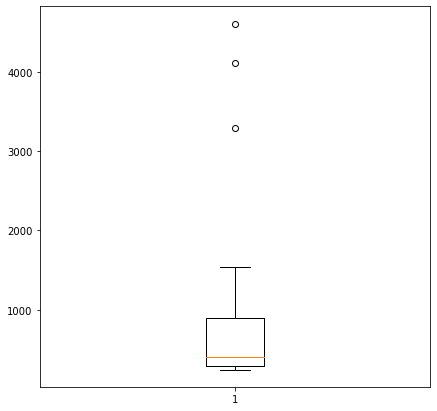

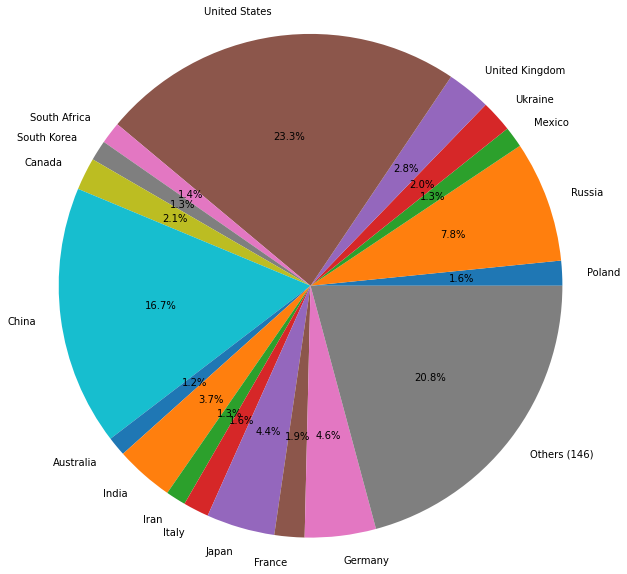

In [13]:
#Graphics
values = []
labels = []
others_value = 0

for index, mean in enumerate(means):
    if mean > 243:
        values.append(mean)
        labels.append(countries.index[index])
    else:
        others_value = others_value + mean

labels.append('Others (' + str(len(means) - len(values)) + ')')
values.append(others_value)
        
print(values)
print(labels)


fig, ax = plt.subplots(figsize=(7, 7))
ax.boxplot(values)

fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(values, labels=labels, autopct='%1.1f%%')
ax1.axis("equal")

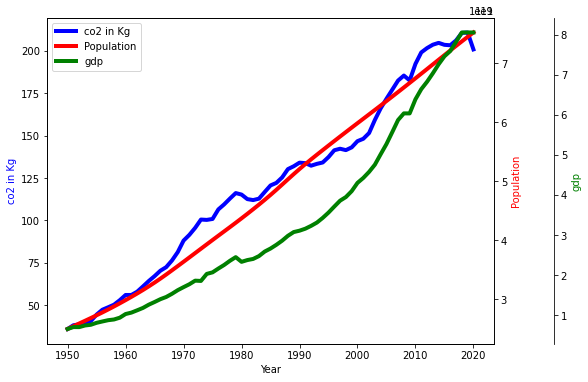

In [14]:
years = filtered_df.year.value_counts(sort=False, ascending=True)

#Calculate co2 mean for each year
co2_means = []
for year in years.index:
    co2_means.append(filtered_df[filtered_df.year == year].co2.mean())

#Calculate gdp mean for each year
gdp_means = []
for year in years.index:
    gdp_means.append(filtered_df[filtered_df.year == year].gdp.mean())

#Calculate population sum for each year
population_sum = []
for year in years.index:
    population_sum.append(filtered_df[filtered_df.year == year].population.sum())

fig, ax_co2 = plt.subplots(figsize=(8,6))
ax_population = ax_co2.twinx()
ax_gdp = ax_co2.twinx()

ax_co2.set_xlabel('Year')
ax_co2.set_ylabel('co2 in Kg')
ax_population.set_ylabel('Population')
ax_gdp.set_ylabel('gdp')

p1, = ax_co2.plot(years.index, co2_means, linewidth=4.0,
                  color='blue', label='co2 in Kg')
p2, = ax_population.plot(years.index, population_sum, linewidth=4.0,    
                         color='red', label='Population')
p3, = ax_gdp.plot(years.index, gdp_means, linewidth=4.0,
                  color='green', label='gdp')

ax_co2.legend(handles=[p1, p2, p3], loc='best')

ax_gdp.spines['right'].set_position(('outward', 60))

ax_co2.yaxis.label.set_color(p1.get_color())
ax_population.yaxis.label.set_color(p2.get_color())
ax_gdp.yaxis.label.set_color(p3.get_color())

Correlation Matrix between co2, population and gdp:

                 co2  population       gdp
co2         1.000000    0.634882  0.881804
population  0.634882    1.000000  0.573223
gdp         0.881804    0.573223  1.000000


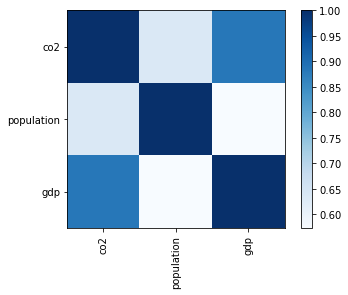

In [15]:
print("Correlation Matrix between co2, population and gdp:\n")
print(filtered_df.loc[:,['co2', 'population', 'gdp']].corr())

df_corr = filtered_df.loc[:,['co2', 'population', 'gdp']]
plt.imshow(df_corr.corr(), cmap = plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(df_corr.columns))]
plt.xticks(tick_marks, df_corr.columns, rotation='vertical')
plt.yticks(tick_marks, df_corr.columns)
plt.show()

In [16]:
climate_df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv')
climate_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [17]:
climate_df = climate_df.filter(['dt','AverageTemperature', 'Country'], axis=1)
climate_df.head()

,dt,AverageTemperature,Country
0,1743-11-01,4.384,Åland
1,1743-12-01,NaN,Åland
2,1744-01-01,NaN,Åland
3,1744-02-01,NaN,Åland
4,1744-03-01,NaN,Åland


In [18]:
print('null values:')
print(climate_df.isna().sum())

null values:
dt                        0
AverageTemperature    32651
Country                   0
dtype: int64


In [19]:
indexes_to_drop = []
for index, row in climate_df.iterrows():
    if int(row[0].split('-')[0]) < 1950:
        indexes_to_drop.append(index)

climate_filtered = climate_df.drop(climate_df.index[indexes_to_drop])

In [20]:
climate_filtered.head(10)

,dt,AverageTemperature,Country
2474,1950-01-01,-5.611,Åland
2475,1950-02-01,-1.804,Åland
2476,1950-03-01,0.090,Åland
2477,1950-04-01,3.630,Åland
2478,1950-05-01,8.106,Åland
2479,1950-06-01,12.783,Åland
2480,1950-07-01,14.604,Åland
2481,1950-08-01,16.482,Åland
2482,1950-09-01,12.326,Åland
2483,1950-10-01,7.808,Åland


In [21]:
def parseMonth(month):
    months = {
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December'
    }
    
    return months.get(month)


#Elaborate dates in order to create year and month columns in the dataframe 
years = []
months = []
for index, row in climate_filtered.iterrows():
    date = row[0].split('-')
    years.append(int(date[0]))
    months.append(parseMonth(int(date[1])))

climate_filtered['Year'] = years
climate_filtered['Month'] = months
climate_filtered.drop('dt', axis=1, inplace=True)
climate_filtered.reset_index(inplace=True)

climate_filtered.head()

,index,AverageTemperature,Country,Year,Month
0,2474,-5.611,Åland,1950,January
1,2475,-1.804,Åland,1950,February
2,2476,0.090,Åland,1950,March
3,2477,3.630,Åland,1950,April
4,2478,8.106,Åland,1950,May


In [22]:
print(climate_filtered[climate_filtered.AverageTemperature.isna() == True].Country.value_counts().sort_values())

#Removing the associated with Antarctica since it has a lot of null values
climate_filtered.drop(climate_filtered[climate_filtered.Country == 'Antarctica'].index, inplace=True)

Suriname                                 1
Bonaire, Saint Eustatius And Saba        1
Bolivia                                  1
Africa                                   1
Albania                                  1
                                      ... 
Yemen                                    1
Uganda                                   1
French Southern And Antarctic Lands      2
Heard Island And Mcdonald Islands        2
Antarctica                             764
Name: Country, Length: 222, dtype: int64


In [23]:
#Caluclate the mean of temperature for each country from 1950
countries = climate_filtered.Country.value_counts()
means = []
for country in countries.index:
    means.append(climate_filtered[climate_filtered.Country == country].AverageTemperature.mean())
        
means_to_series = pd.Series(means)

#Calculate temperature mean
mean = means_to_series.mean()
print('Temperature mean: ', round(mean, 3))
print('---------------------------------------------')

#Calculate temperature median
median = means_to_series.median()
print('Temperature median: ', round(median, 3))
print('---------------------------------------------')

#Calculate temperature variance
variance = means_to_series.var()
print('Temperature variance: ', round(variance, 3))
print('---------------------------------------------')

#Calculate temperature standard deviation
standard_deviation = means_to_series.std()
print('Temperature standard deviation: ', round(standard_deviation, 3))
print('---------------------------------------------')

#Calculate temperature mean absolute deviation
mean_absolute_deviation = means_to_series.mad()
print('Temperature mean absolute deviation: ', round(mean_absolute_deviation, 3))
print('---------------------------------------------')

Temperature mean:  18.996
---------------------------------------------
Temperature median:  23.088
---------------------------------------------
Temperature variance:  83.559
---------------------------------------------
Temperature standard deviation:  9.141
---------------------------------------------
Temperature mean absolute deviation:  7.778
---------------------------------------------


In [24]:
#Replacing null values with the mean of each country
countries_with_null = climate_filtered[climate_filtered.AverageTemperature.isna() == True].Country.value_counts()

means = []
for country in countries_with_null.index:
    mean = climate_filtered[climate_filtered.Country == country].AverageTemperature.mean()
    means.append((country, mean))
    
for country, mean in means:
    climate_filtered.loc[(climate_filtered.Country == country) & (climate_filtered.AverageTemperature.isna() == True), 
                         'AverageTemperature'] = mean

In [25]:
print('null values:')
print(climate_filtered.isna().sum())

null values:
index                 0
AverageTemperature    0
Country               0
Year                  0
Month                 0
dtype: int64


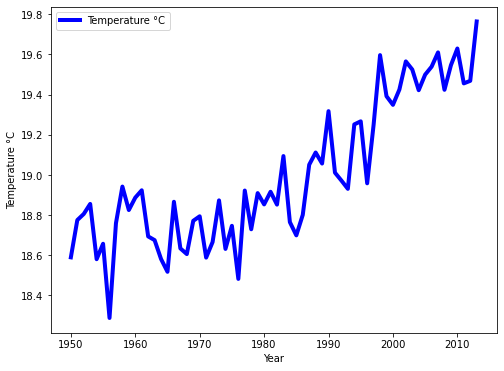

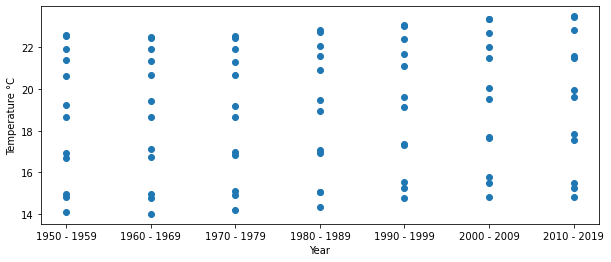

In [26]:
years = climate_filtered.Year.value_counts(sort=False, ascending=True)

#Calculate average temperature mean for each year
temperature_means = []
for year in years.index:
    temperature_means.append(climate_filtered[climate_filtered.Year == year].AverageTemperature.mean())
    
fig, ax_temperature = plt.subplots(figsize=(8,6))

ax_temperature.set_xlabel('Year')
ax_temperature.set_ylabel('Temperature °C')

p1, = ax_temperature.plot(years.index, temperature_means, linewidth=4.0,
                          color='blue', label='Temperature °C')

ax_temperature.legend(handles=[p1], loc='best')
plt.show()


#Calculating the mean of each month for each year
years_range = [(1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2019)]
x_axis = []
y_axis = []
months = climate_filtered.Month.unique()
for year_from, year_to in years_range:
    for month in months:
        x_axis.append(f'{year_from} - {year_to}')
        y_axis.append(climate_filtered[(year_from <= climate_filtered.Year) & (climate_filtered.Year <= year_to) & (climate_filtered.Month == month)].AverageTemperature.mean())

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel('Year')
ax.set_ylabel('Temperature °C')
ax.scatter(x_axis, y_axis)
plt.show()

In [27]:
#Merging the two datasets
print(filtered_df.head())
print(climate_filtered.head())

       country  year    co2  population           gdp
1  Afghanistan  1950  0.084   7752117.0  9.421400e+09
2  Afghanistan  1951  0.092   7840151.0  9.692280e+09
3  Afghanistan  1952  0.092   7935996.0  1.001733e+10
4  Afghanistan  1953  0.106   8039684.0  1.063052e+10
5  Afghanistan  1954  0.106   8151316.0  1.086636e+10
   index  AverageTemperature Country  Year     Month
0   2474              -5.611   Åland  1950   January
1   2475              -1.804   Åland  1950  February
2   2476               0.090   Åland  1950     March
3   2477               3.630   Åland  1950     April
4   2478               8.106   Åland  1950       May


In [28]:
#Getting all the countries that are in the two datasets
countries1 = set(filtered_df.country.unique())
countries2 = set(climate_filtered.Country.unique())

countries_in_common = list(countries1 & countries2)

#Removing the countries that are not in common in order to merge the two datasets
df1 = filtered_df[filtered_df.country.isin(countries_in_common)]
df2 = climate_filtered[climate_filtered.Country.isin(countries_in_common)]

#Since in climate_filtered dataframe there are entries associated to year until 2013, 
#the entries of filtered_df that are associated to the years greater than 2013 are removed
#In irder to merge the two dataframes
years1 = set(filtered_df.year.unique())
years2 = set(climate_filtered.Year.unique())

years_in_common = list(years1 & years2)
df1 = filtered_df[filtered_df.year.isin(years_in_common)]

#suppress warnings
pd.options.mode.chained_assignment = None
#Merging the two datasets
for index, row in df1.iterrows():
    df2.loc[(df2.Country == row[0]) & (df2.Year == row[1]), 'co2'] = row[2]
    df2.loc[(df2.Country == row[0]) & (df2.Year == row[1]), 'population'] = row[3]
    df2.loc[(df2.Country == row[0]) & (df2.Year == row[1]), 'gdp'] = row[4]
    
df2.head()

,index,AverageTemperature,Country,Year,Month,co2,population,gdp
765,4580,-0.048,Afghanistan,1950,January,0.084,7752117.0,9.421400e+09
766,4581,0.159,Afghanistan,1950,February,0.084,7752117.0,9.421400e+09
767,4582,7.541,Afghanistan,1950,March,0.084,7752117.0,9.421400e+09
768,4583,12.031,Afghanistan,1950,April,0.084,7752117.0,9.421400e+09
769,4584,20.487,Afghanistan,1950,May,0.084,7752117.0,9.421400e+09


In [29]:
#Calculating the average year temperature change from the year 1950 for each country
countries = df2.Country.unique()
years = df2.Year.unique()

means = []
for year in years:
    for country in countries:
        start_mean = df2[(df2.Year == 1950) & (df2.Country == country)].AverageTemperature.mean()
        mean = df2[(df2.Year == year) & (df2.Country == country)].AverageTemperature.mean()
        means.append((year, country, abs(mean-start_mean)))
    
for year, country, mean in means:
    df2.loc[(df2.Year == year) & (df2.Country == country), 'AverageYearTemperatureChange'] = mean

df2.head()

,index,AverageTemperature,Country,Year,Month,co2,population,gdp,AverageYearTemperatureChange
765,4580,-0.048,Afghanistan,1950,January,0.084,7752117.0,9.421400e+09,0.0
766,4581,0.159,Afghanistan,1950,February,0.084,7752117.0,9.421400e+09,0.0
767,4582,7.541,Afghanistan,1950,March,0.084,7752117.0,9.421400e+09,0.0
768,4583,12.031,Afghanistan,1950,April,0.084,7752117.0,9.421400e+09,0.0
769,4584,20.487,Afghanistan,1950,May,0.084,7752117.0,9.421400e+09,0.0


In [30]:
df2.head(20)

,index,AverageTemperature,Country,Year,Month,co2,population,gdp,AverageYearTemperatureChange
765,4580,-0.048,Afghanistan,1950,January,0.084,7752117.0,9.421400e+09,0.00000
766,4581,0.159,Afghanistan,1950,February,0.084,7752117.0,9.421400e+09,0.00000
767,4582,7.541,Afghanistan,1950,March,0.084,7752117.0,9.421400e+09,0.00000
768,4583,12.031,Afghanistan,1950,April,0.084,7752117.0,9.421400e+09,0.00000
769,4584,20.487,Afghanistan,1950,May,0.084,7752117.0,9.421400e+09,0.00000
770,4585,25.083,Afghanistan,1950,June,0.084,7752117.0,9.421400e+09,0.00000
771,4586,27.455,Afghanistan,1950,July,0.084,7752117.0,9.421400e+09,0.00000
772,4587,25.357,Afghanistan,1950,August,0.084,7752117.0,9.421400e+09,0.00000
773,4588,19.043,Afghanistan,1950,September,0.084,7752117.0,9.421400e+09,0.00000
774,4589,14.451,Afghanistan,1950,October,0.084,7752117.0,9.421400e+09,0.00000


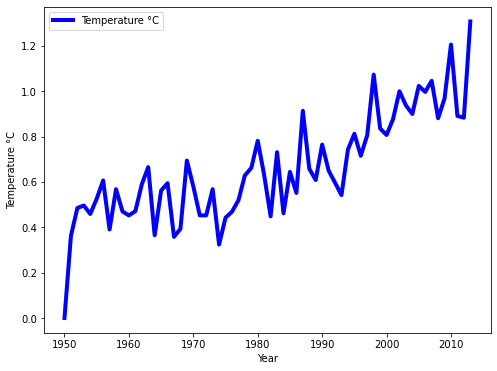

In [31]:
years = list(df2.Year.unique())
mean_temp_change = []
for year in years:
    mean_temp_change.append(df2[df2.Year == year].AverageYearTemperatureChange.mean())
    
fig, ax_temperature = plt.subplots(figsize=(8,6))

ax_temperature.set_xlabel('Year')
ax_temperature.set_ylabel('Temperature °C')

p1, = ax_temperature.plot(years, mean_temp_change, linewidth=4.0,
                          color='blue', label='Temperature °C')

ax_temperature.legend(handles=[p1], loc='best')
plt.show()

Correlation Matrix between average temperature, co2, population and gdp:

                                   co2  population       gdp  \
co2                           1.000000    0.580378  0.926085   
population                    0.580378    1.000000  0.555268   
gdp                           0.926085    0.555268  1.000000   
AverageYearTemperatureChange  0.032733    0.007619  0.042509   

                              AverageYearTemperatureChange  
co2                                               0.032733  
population                                        0.007619  
gdp                                               0.042509  
AverageYearTemperatureChange                      1.000000  


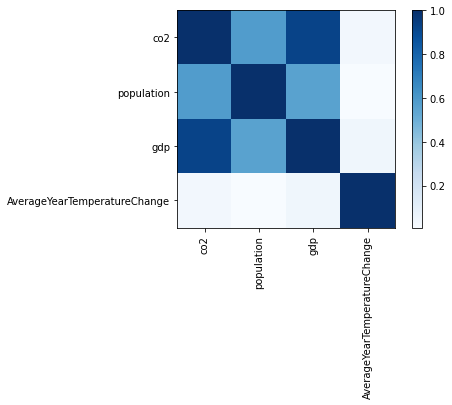

In [32]:
#Correlation matrix
print("Correlation Matrix between average temperature, co2, population and gdp:\n")
print(df2.loc[:,['co2', 'population', 'gdp', 'AverageYearTemperatureChange']].corr())

df_corr = df2.loc[:,['co2', 'population', 'gdp', 'AverageYearTemperatureChange']]
plt.imshow(df_corr.corr(), cmap = plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(df_corr.columns))]
plt.xticks(tick_marks, df_corr.columns, rotation='vertical')
plt.yticks(tick_marks, df_corr.columns)
plt.show()

In [61]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Linear regression model
def model_fit(x_train, y_train):
    
    model = linear_model.LinearRegression().fit(x_train, y_train)

    LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
    
    return model

In [93]:
df_regression = df2.copy()
df_regression.drop(columns=['index', 'Month', 'AverageTemperature'], inplace=True)
df_regression.drop_duplicates(inplace=True)
df_regression.reset_index(drop=True, inplace=True)

df_regression.head()

,Country,Year,co2,population,gdp,AverageYearTemperatureChange
0,Afghanistan,1950,0.084,7752117.0,9.421400e+09,0.000000
1,Afghanistan,1951,0.092,7840151.0,9.692280e+09,0.924250
2,Afghanistan,1952,0.092,7935996.0,1.001733e+10,1.131917
3,Afghanistan,1953,0.106,8039684.0,1.063052e+10,1.607250
4,Afghanistan,1954,0.106,8151316.0,1.086636e+10,0.647833


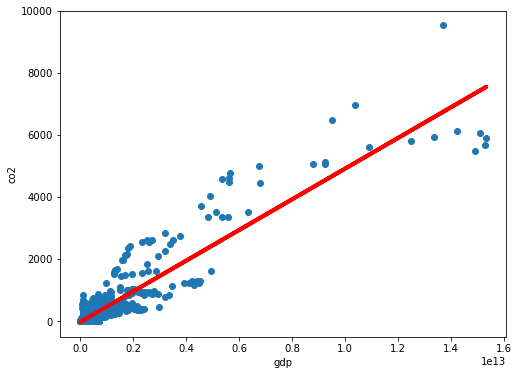

Score of the regression model: 0.8550028460977324


In [103]:
#LINEAR REGRESSION BETWEEN gdp AND co2

df_x = pd.DataFrame(df_regression.loc[:, 'gdp'])
df_y = pd.DataFrame(df_regression.loc[:, 'co2'])

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size= 0.3, random_state = 7)

model = linear_model.LinearRegression().fit(x_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
score = model.score(x_train, y_train)

fig, ax = plt.subplots(figsize=(8,6))

ax.set_xlabel('gdp')
ax.set_ylabel('co2')

ax.plot(x_test.squeeze(), model.predict(x_test), linewidth=4.0,
        color='red')
ax.scatter(x_test, y_test)

plt.show()

print(f'Score of the regression model: {score}')

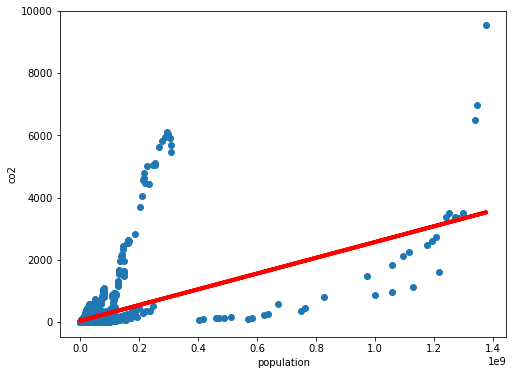

Score of the regression model: 0.32473432830451465


In [106]:
#LINEAR REGRESSION BETWEEN population AND co2

df_x = pd.DataFrame(df_regression.loc[:, 'population'])
df_y = pd.DataFrame(df_regression.loc[:, 'co2'])

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size= 0.3, random_state = 7)

model = linear_model.LinearRegression().fit(x_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
score = model.score(x_train, y_train)

fig, ax = plt.subplots(figsize=(8,6))

ax.set_xlabel('population')
ax.set_ylabel('co2')

ax.plot(x_test.squeeze(), model.predict(x_test), linewidth=4.0,
        color='red')
ax.scatter(x_test, y_test)

plt.show()

print(f'Score of the regression model: {score}')

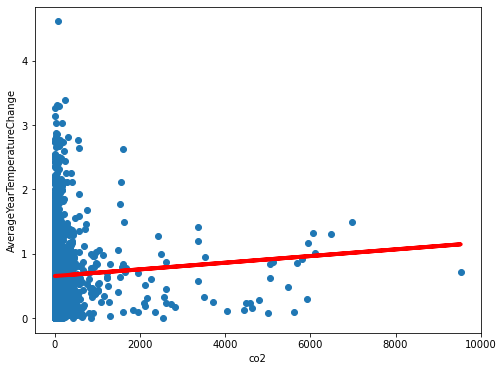

Score of the regression model: 0.0023190510494903727


In [105]:
#LINEAR REGRESSION BETWEEN AverageYearTemperatureChange AND co2

df_x = pd.DataFrame(df_regression.loc[:, 'co2'])
df_y = pd.DataFrame(df_regression.loc[:, 'AverageYearTemperatureChange'])

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size= 0.3, random_state = 7)

model = linear_model.LinearRegression().fit(x_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
score = model.score(x_train, y_train)

fig, ax = plt.subplots(figsize=(8,6))

ax.set_xlabel('co2')
ax.set_ylabel('AverageYearTemperatureChange')

ax.plot(x_test.squeeze(), model.predict(x_test), linewidth=4.0,
        color='red')
ax.scatter(x_test, y_test)

plt.show()

print(f'Score of the regression model: {score}')